# Mostra os graficos e dotplot para valores observados para uma iteracao do SWATCUP.

In [1]:
import glob
import os
import os
import time
import pandas as pd
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
ITERATION_BASE_FOLDER = '../20200729-precip corrigida/20200730_cal_novo_pcp_montante.Sufi2.SwatCup/Iterations'
ITERATION_NAME = None    #Quando None ele pega a iteracao mais recente
#ITERATION_NAME = '20200805_1828_all_calib dani'

In [3]:
# Prepara path de diretorios
if ITERATION_NAME is None:
    # Pega diretorio mais novo
    directories = glob.glob(os.path.join(ITERATION_BASE_FOLDER, '*/'))
    iter_folder = max(directories, key=os.path.getmtime)
    print('Iteracao nao definida. Utilizando a iteracao mais recente')
else:
    # Se o nome foi definido usa o nome definido
    iter_folder = os.path.join(ITERATION_BASE_FOLDER, ITERATION_NAME)

echo_folder = os.path.join(iter_folder, 'Echo')
sufi_in_folder = os.path.join(iter_folder, 'Sufi2.In')
sufi_out_folder = os.path.join(iter_folder, 'Sufi2.Out')
                           
iter_folder

Iteracao nao definida. Utilizando a iteracao mais recente


'../20200729-precip corrigida/20200730_cal_novo_pcp_montante.Sufi2.SwatCup/Iterations\\20200825_1148\\'

## Valores extraidos do modelo

In [4]:
# Coleta nome dos arquivos de dados extraidoa
#Se tiver mais de um arquivo com os nomes de variaveis (rch, sub, etc), colocar na lista
extracted_files_index = ['var_file_rch.txt']    
extracted_files = []
for f in extracted_files_index:
    file = os.path.join(sufi_in_folder, f)
    with open(file) as fo:
        extracted_files = extracted_files + fo.read().splitlines()
variable_id = { os.path.splitext(extracted_files[i])[0] : i for i in range(0, len(extracted_files) ) }
variable_id

{'FLOW_OUT_5': 0,
 'FLOW_OUT_8': 1,
 'FLOW_OUT_11': 2,
 'FLOW_OUT_13': 3,
 'FLOW_OUT_14': 4,
 'FLOW_OUT_17': 5,
 'FLOW_OUT_18': 6,
 'FLOW_OUT_21': 7,
 'FLOW_OUT_22': 8,
 'FLOW_OUT_23': 9,
 'FLOW_OUT_24': 10,
 'FLOW_OUT_25': 11,
 'FLOW_OUT_27': 12,
 'FLOW_OUT_29': 13,
 'FLOW_OUT_34': 14,
 'FLOW_OUT_36': 15,
 'FLOW_OUT_37': 16,
 'SED_OUT_5': 17,
 'SED_OUT_8': 18,
 'SED_OUT_14': 19,
 'SED_OUT_21': 20,
 'SED_OUT_24': 21,
 'SED_OUT_34': 22}

In [5]:
# Le todos arquivo de dados extraidos
extracted = []
batch_list = []
df_list = []
first = True
for file in extracted_files:
    print('Lendo arquivo: {}'.format(file))
    file = os.path.join(sufi_out_folder, file)
    with open(file) as fo:
        extracted_var = fo.readlines()
    extracted_var = [x.strip().split() for x in extracted_var]
    step_list = []
    value_list = []
    mat_list = []
    first = True
    batch_list = []
    for line in extracted_var:
        # Verifica se eh o numero da rodada
        if len(line) == 1:
            if not first:
                mat_list.append(value_list)
            batch_list.append(int(line[0]))
            value_list = []
            step_list = []
            first = False
        if len(line) == 2:
            step_list.append(int(line[0]))
            value_list.append(float(line[1]))
            
    mat_list.append(value_list)

    # cria dataframe
    df = pd.DataFrame(mat_list).transpose()
    # Seta nome de colunas
    df.columns = batch_list
    # Coloca os steps com indice
    df['step'] = pd.Series(step_list)
    df = df.set_index('step')
    
    # Coloca dataframe dentro da lista observados
    extracted.append(df)

Lendo arquivo: FLOW_OUT_5.txt
Lendo arquivo: FLOW_OUT_8.txt
Lendo arquivo: FLOW_OUT_11.txt
Lendo arquivo: FLOW_OUT_13.txt
Lendo arquivo: FLOW_OUT_14.txt
Lendo arquivo: FLOW_OUT_17.txt
Lendo arquivo: FLOW_OUT_18.txt
Lendo arquivo: FLOW_OUT_21.txt
Lendo arquivo: FLOW_OUT_22.txt
Lendo arquivo: FLOW_OUT_23.txt
Lendo arquivo: FLOW_OUT_24.txt
Lendo arquivo: FLOW_OUT_25.txt
Lendo arquivo: FLOW_OUT_27.txt
Lendo arquivo: FLOW_OUT_29.txt
Lendo arquivo: FLOW_OUT_34.txt
Lendo arquivo: FLOW_OUT_36.txt
Lendo arquivo: FLOW_OUT_37.txt
Lendo arquivo: SED_OUT_5.txt
Lendo arquivo: SED_OUT_8.txt
Lendo arquivo: SED_OUT_14.txt
Lendo arquivo: SED_OUT_21.txt
Lendo arquivo: SED_OUT_24.txt
Lendo arquivo: SED_OUT_34.txt


## Valores observados

In [6]:
# Coleta nome dos arquivos de dados observados
#Se tiver mais de um arquivo com os nomes de variaveis (rch, sub, etc), colocar na lista
observed_files = ['observed_rch.txt']
for f in observed_files:
    file = os.path.join(sufi_in_folder, f)
    with open(file) as fo:
        lines = fo.read().splitlines()
        # remove linhas em branco
        lines = list(filter(None, lines))
    # processa
    number_observed_var = int(lines[0].split(':')[0])
    print('Numero de variaveis declaradas: {}'.format(number_observed_var))
    config_list = []
    config_section = False
    first = True
    step_list = []
    value_list = []
    mat_list = []
    first = True
    for line in lines[1:]:
        p = line.split(':')
        if len(p) > 1:
            if not config_section:
                # Nao estava numa secao de configuracao. Abre um secao nova
                if not first:
                    config_list.append(var_config)
                    mat_list.append([step_list,value_list])
                first = False
                var_config =[]
                config_section = True
                step_list = []
                value_list = []
                    
            # tem um sinal de :, deve ser alguma configuracao
            var_config.append(line)
        else:
            config_section = False
            # Le dados
            observed_var = line.split()
            step_list.append(int(observed_var[0]))
            value_list.append(float(observed_var[2]))
    
    # Salva ultima iteracao
    config_list.append(var_config)
    mat_list.append([step_list, value_list])
    
    number_obs_detected = len(mat_list)
    if number_observed_var != number_obs_detected:
        print('Numero de variaveis detectadas diferente do declarado: {} != {}'.format(number_observed_var, number_obs_detected))
    

    # cria dataframe. Para manter correspondencia com os dados extraidos
    # é criada uma lista de dataframes
    observed = []
    obs_name_list = []
    for serie, config in zip(mat_list, config_list):
        # TODO: isso aqui pega no nome da variavel. Não é muito robusto. Melhorar se precisar
        name = (config[0].split(':')[0].strip())
        obs_name_list.append(name)
        df = pd.DataFrame({name:serie[1]})
        df['step'] = pd.Series(serie[0])
        df = df.set_index('step') 
        observed.append(df)
        
    # certifica que os dados observados estao na mesma ordem que os dados extraidos
    if len(obs_name_list) != len(variable_id):
        print('ATENCAO: o numero de variaveis extraidas eh diferente do numero de variaveis observadas: {} != {}'.format(len(obs_name_list),len(variable_id)))
    #ordered = []
    #for i, name in enumerate(obs_name_list):
    #    ordered.append(variable_id[name])
    #ordered = [variable_id[name] for name in obs_name_list]
    #obs_name_list[1],obs_name_list[2] = obs_name_list[2],obs_name_list[1]
    fix_order = [obs_name_list.index(name) for name in variable_id.keys()]
    observed = [observed[i] for i in fix_order]

Numero de variaveis declaradas: 23


## Parametros utilizados

In [7]:
param_file = os.path.join(sufi_out_folder, 'goal.txt')
params = pd.read_csv(param_file, skiprows=3, decimal='.', delim_whitespace=True)  
params = params.set_index('Sim_No.')

In [8]:
params

,1:R__FILTERW.mgt,2:V__LAT_SED.hru,3:V__ADJ_PKR.bsn,4:V__USLE_P.mgt,5:R__SLSUBBSN.hru,6:V__USLE_C{..}.plant.dat,7:V__USLE_C{..}.plant.dat,8:V__USLE_C{..}.plant.dat,9:V__SPCON.bsn,10:V__SPEXP.bsn,...,43:V__LAT_TTIME.hru,44:V__SURLAG.bsn,45:R__CN2.mgt,46:V__GW_DELAY.gw,47:V__ESCO.hru,48:V__SHALLST.gw,49:V__GWQMN.gw,50:V__ALPHA_BF.gw,51:V__LAT_TTIME.hru,goal_value
Sim_No.,,,,,,,,,,,,,,,,,,,,,
1,0.0,4.375,1.2625,0.5995,0.0,0.331,0.365,0.367,0.0038,1.4043,...,6.6,6.0,-0.25,500.0,0.695,1000.0,325.0,0.4723,8.5,-72.795110
2,0.0,3.875,1.2425,0.5845,0.0,0.345,0.203,0.315,0.0037,1.4392,...,6.6,6.0,-0.25,500.0,0.695,1000.0,325.0,0.4723,8.5,-33.719775
3,0.0,3.725,1.4125,0.5655,0.0,0.265,0.387,0.337,0.0032,1.4473,...,6.6,6.0,-0.25,500.0,0.695,1000.0,325.0,0.4723,8.5,-47.931352
4,0.0,1.275,1.2025,0.5935,0.0,0.371,0.399,0.221,0.0030,1.4447,...,6.6,6.0,-0.25,500.0,0.695,1000.0,325.0,0.4723,8.5,-66.732311
5,0.0,1.375,1.0775,0.5085,0.0,0.257,0.265,0.217,0.0031,1.4123,...,6.6,6.0,-0.25,500.0,0.695,1000.0,325.0,0.4723,8.5,-27.368095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.0,4.125,1.2225,0.5925,0.0,0.359,0.367,0.303,0.0033,1.4353,...,6.6,6.0,-0.25,500.0,0.695,1000.0,325.0,0.4723,8.5,-70.359830
97,0.0,1.675,1.4025,0.5545,0.0,0.393,0.305,0.297,0.0033,1.4253,...,6.6,6.0,-0.25,500.0,0.695,1000.0,325.0,0.4723,8.5,-57.213509
98,0.0,4.025,1.4225,0.5395,0.0,0.213,0.353,0.345,0.0033,1.4288,...,6.6,6.0,-0.25,500.0,0.695,1000.0,325.0,0.4723,8.5,-63.265245


In [9]:
goal_swatcup = params['goal_value']
params = params.drop(columns=['goal_value'])

## Processa e visualiza dados por bacia

In [10]:
def evaluation_metric(function, simulated, observed):
    import hydroeval
    if function == 'nse':
        return hydroeval.evaluator(hydroeval.nse, simulated.to_numpy(), observed.to_numpy())
    if function == 'rmse':
        return hydroeval.evaluator(hydroeval.rmse, simulated.to_numpy(), observed.to_numpy())
    if function == 'pbias':
        return hydroeval.evaluator(hydroeval.pbias, simulated.to_numpy(), observed.to_numpy())
    if function == 'kge':
        return hydroeval.evaluator(hydroeval.kge, simulated.to_numpy(), observed.to_numpy())
    
    else:
        print('Funcao desconhecida {}'.format(function))

In [11]:
variable_id

{'FLOW_OUT_5': 0,
 'FLOW_OUT_8': 1,
 'FLOW_OUT_11': 2,
 'FLOW_OUT_13': 3,
 'FLOW_OUT_14': 4,
 'FLOW_OUT_17': 5,
 'FLOW_OUT_18': 6,
 'FLOW_OUT_21': 7,
 'FLOW_OUT_22': 8,
 'FLOW_OUT_23': 9,
 'FLOW_OUT_24': 10,
 'FLOW_OUT_25': 11,
 'FLOW_OUT_27': 12,
 'FLOW_OUT_29': 13,
 'FLOW_OUT_34': 14,
 'FLOW_OUT_36': 15,
 'FLOW_OUT_37': 16,
 'SED_OUT_5': 17,
 'SED_OUT_8': 18,
 'SED_OUT_14': 19,
 'SED_OUT_21': 20,
 'SED_OUT_24': 21,
 'SED_OUT_34': 22}

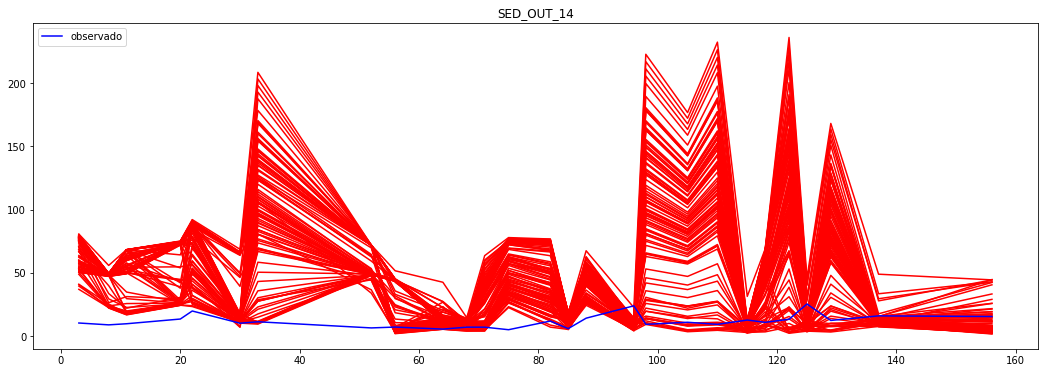

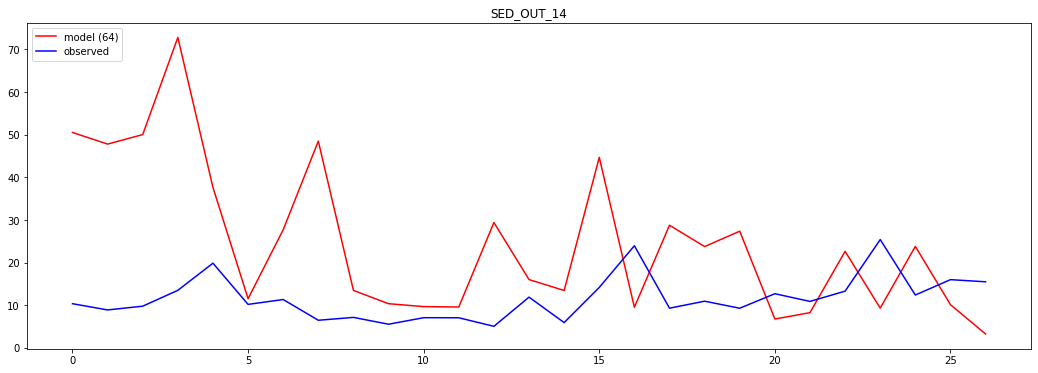

pbias: [-112.30002547]
nse: [-19.52220113]
rmse: [22.81837976]
kge: [-1.9299731]


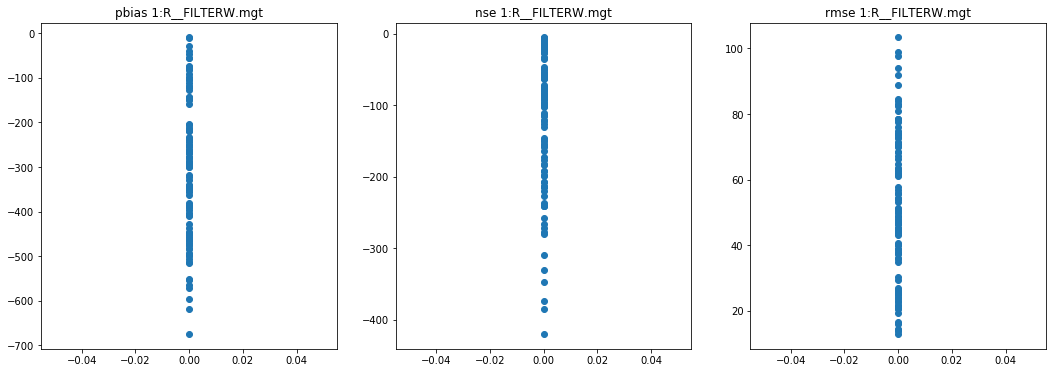

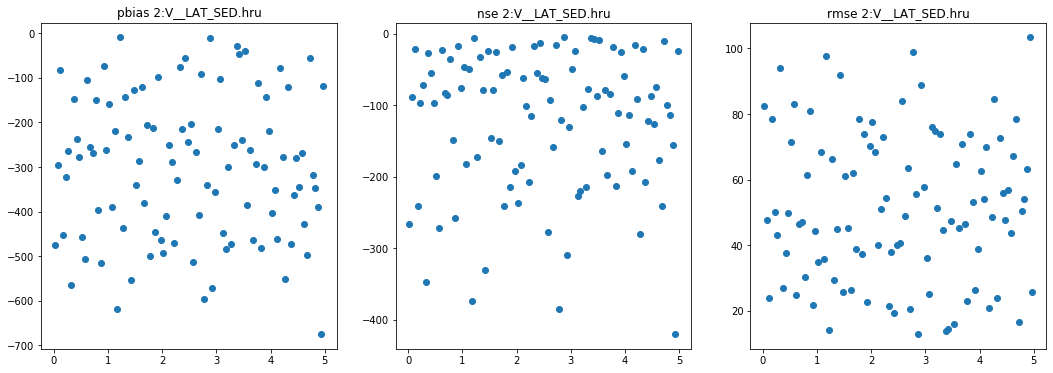

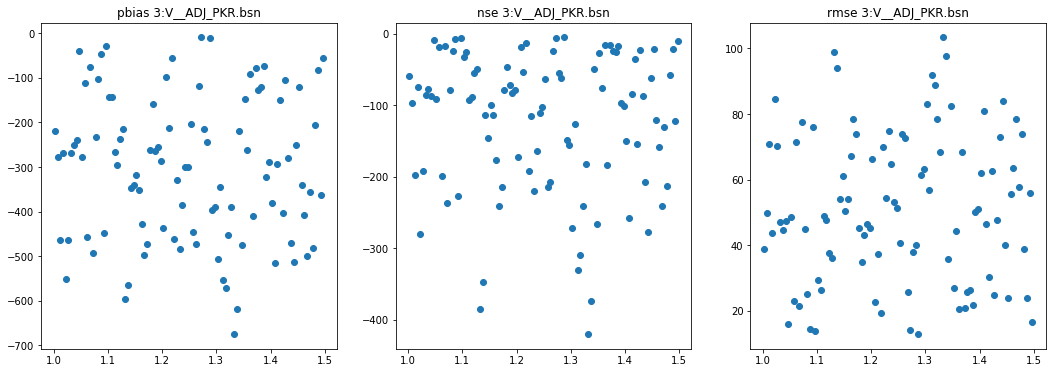

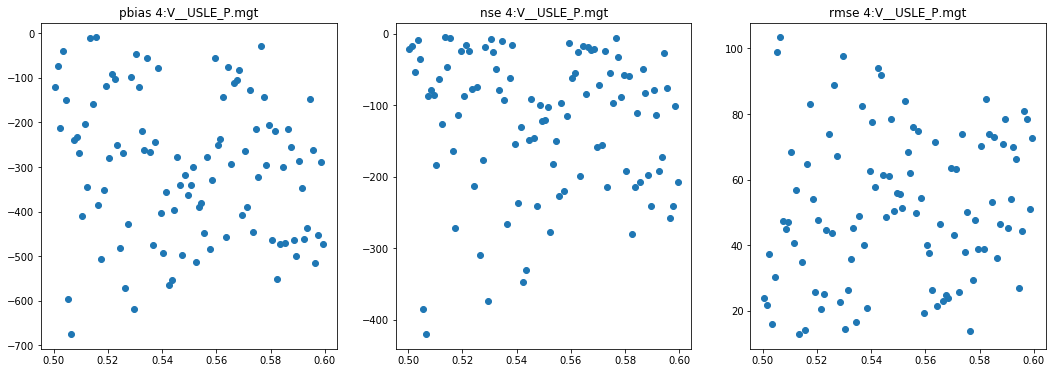

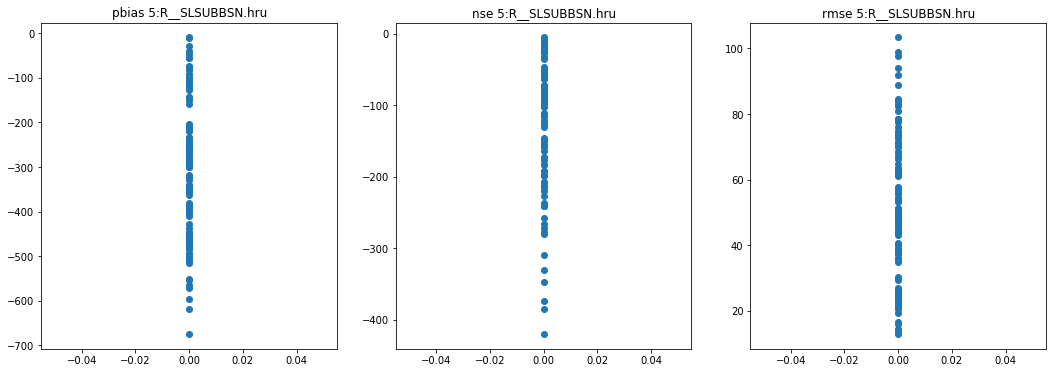

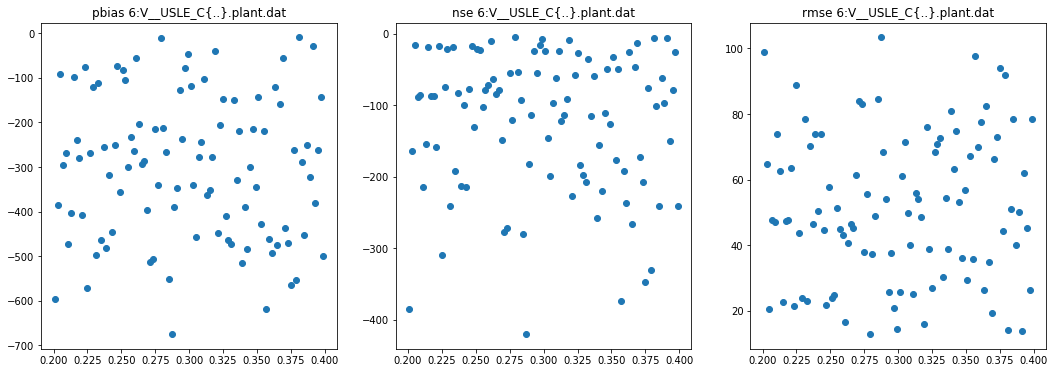

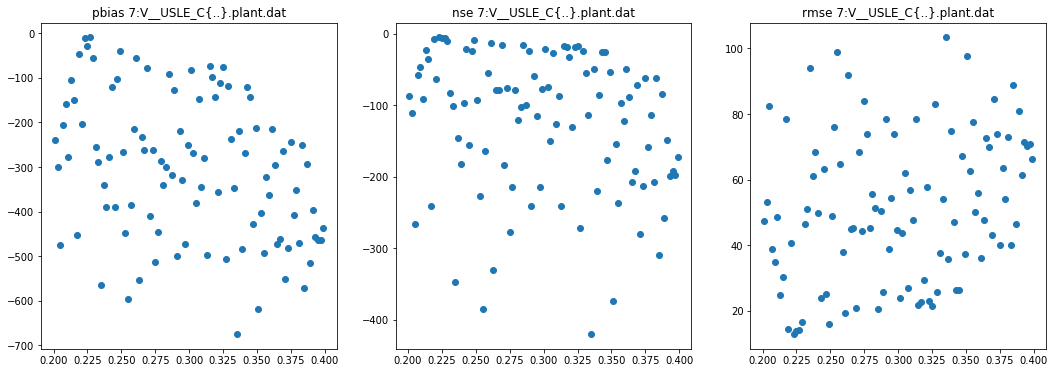

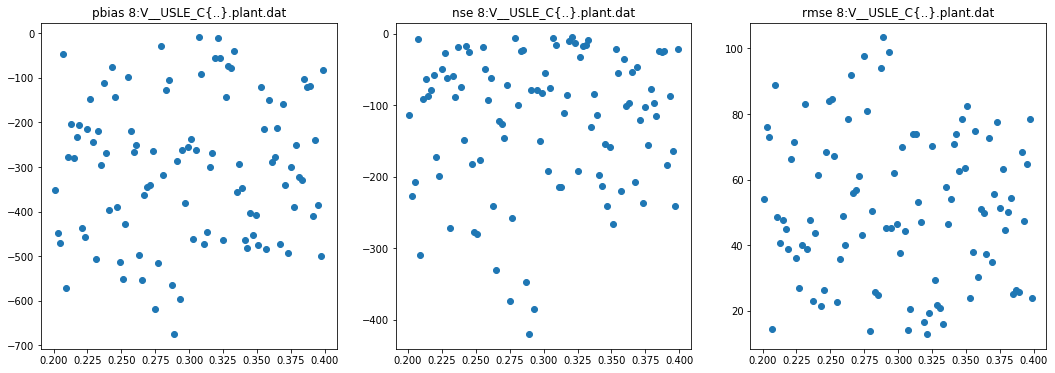

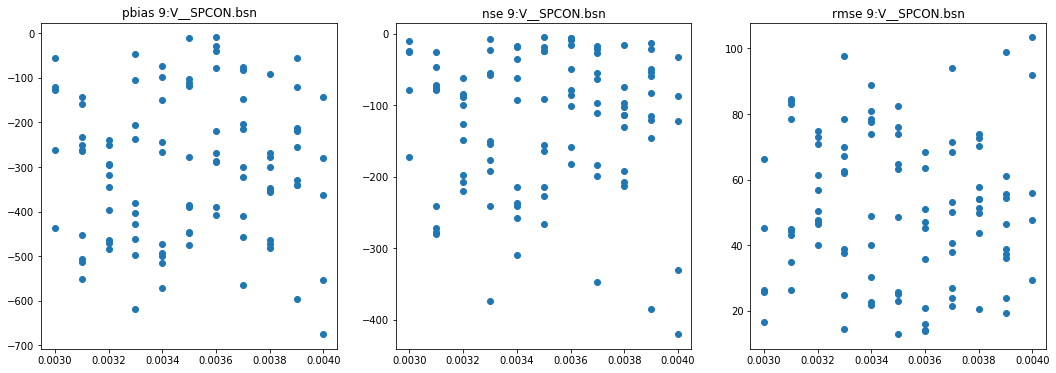

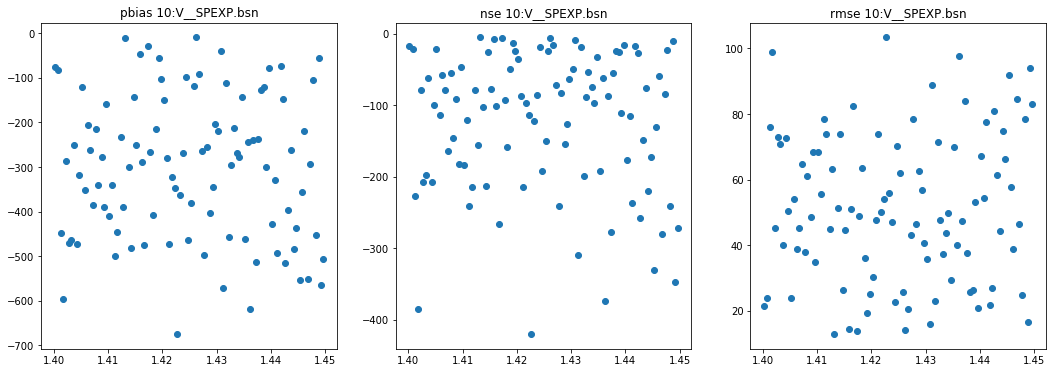

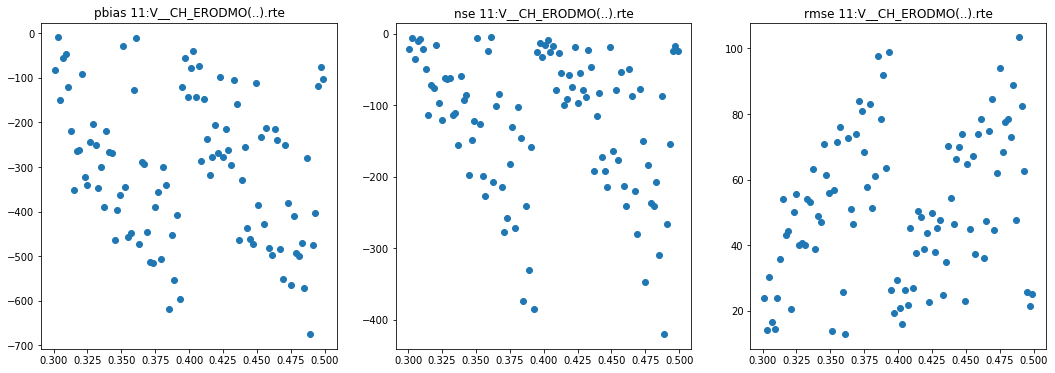

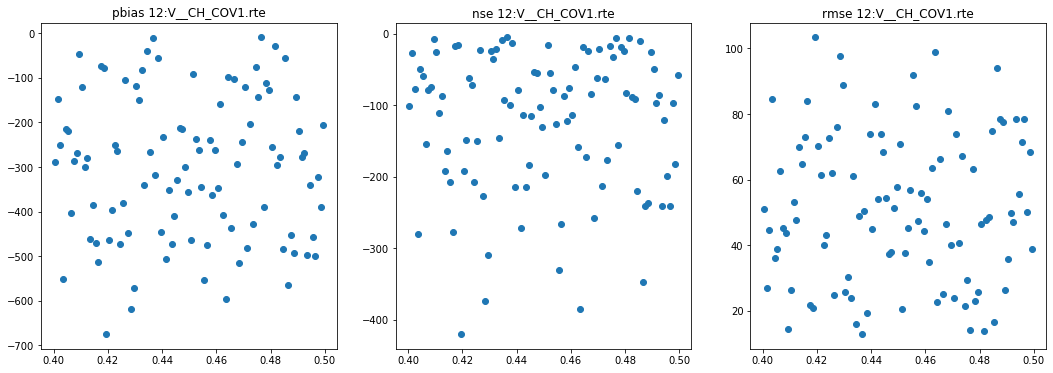

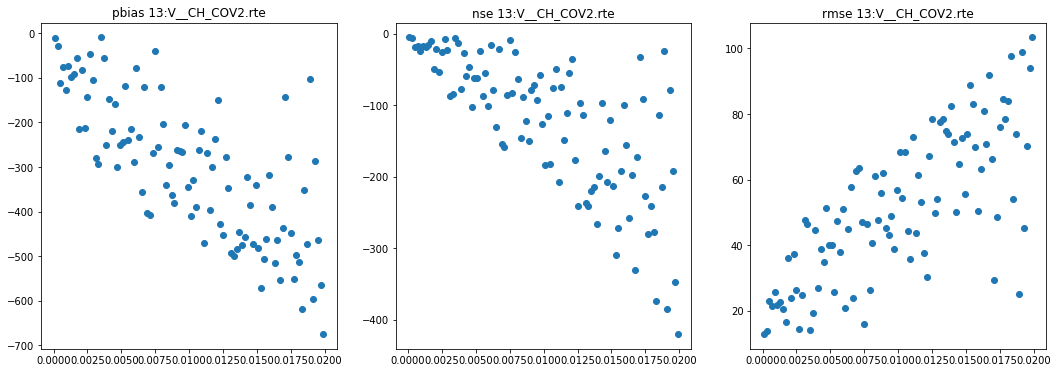

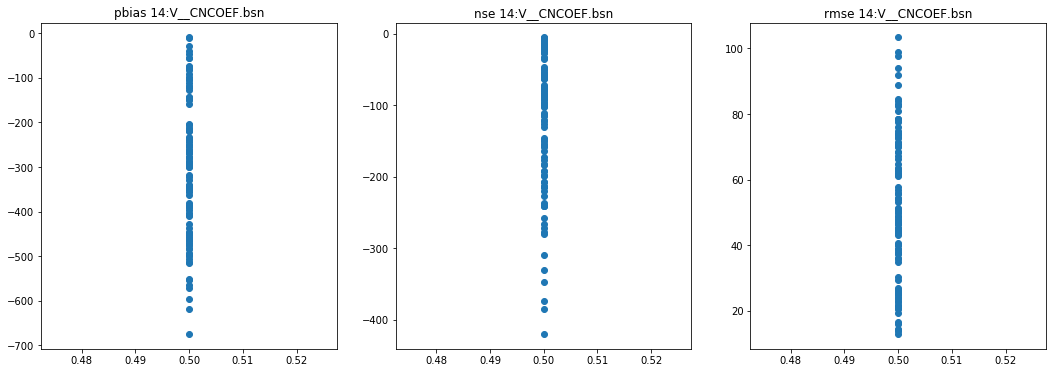

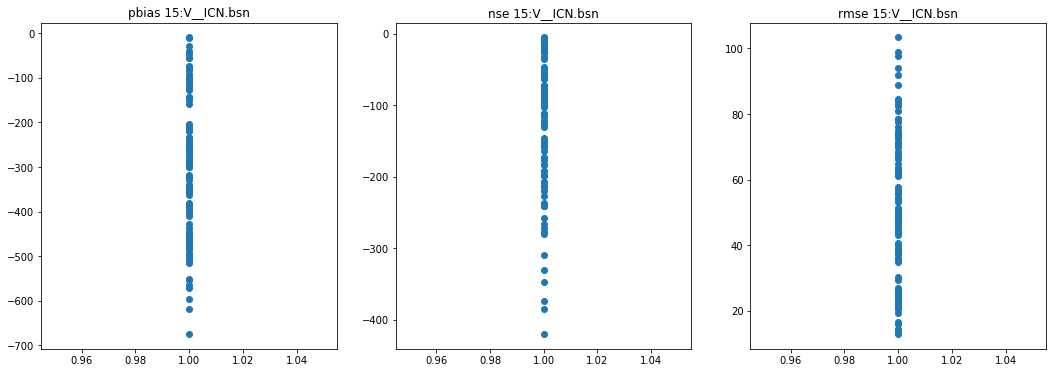

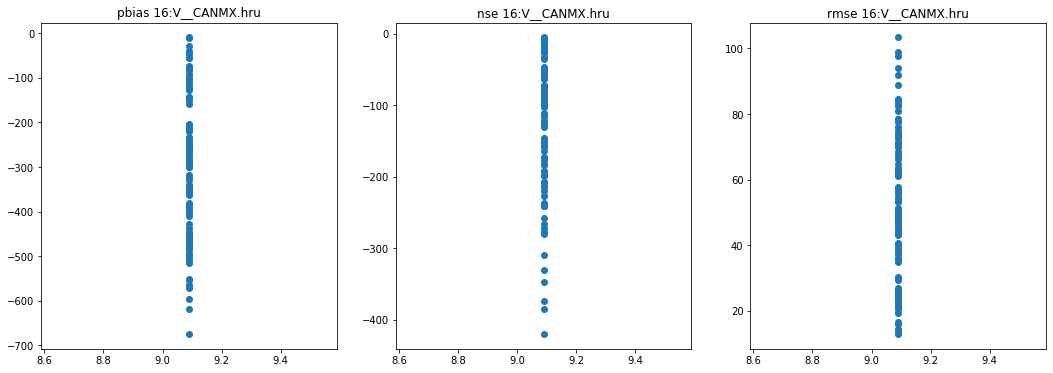

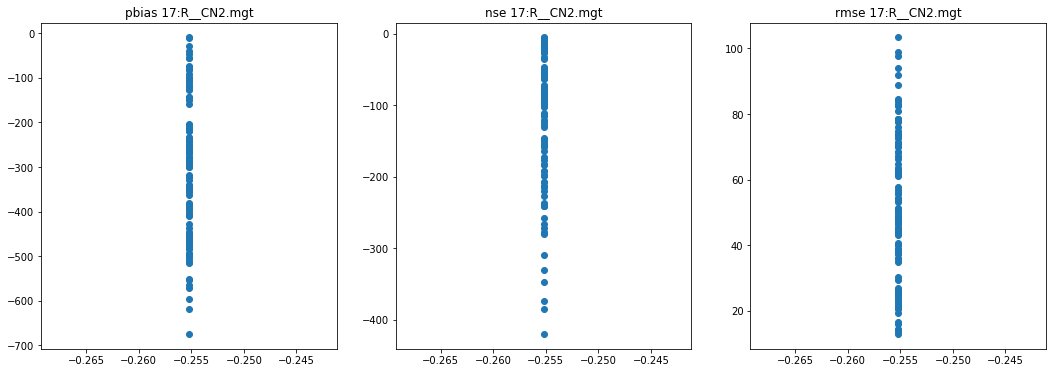

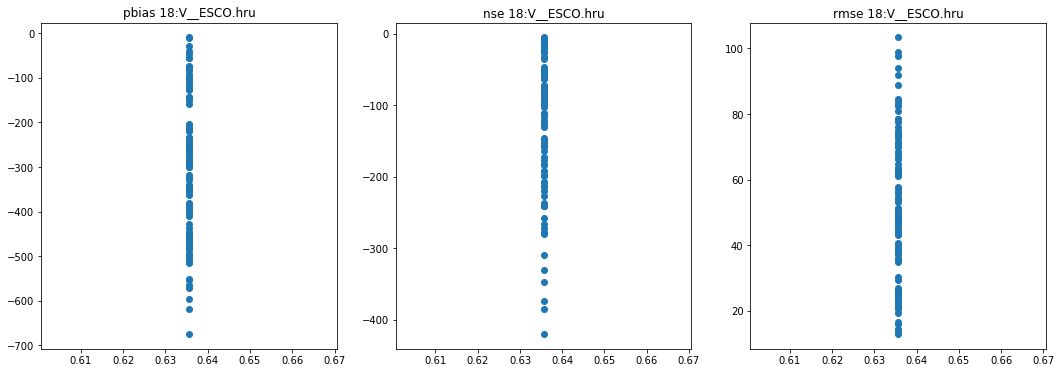

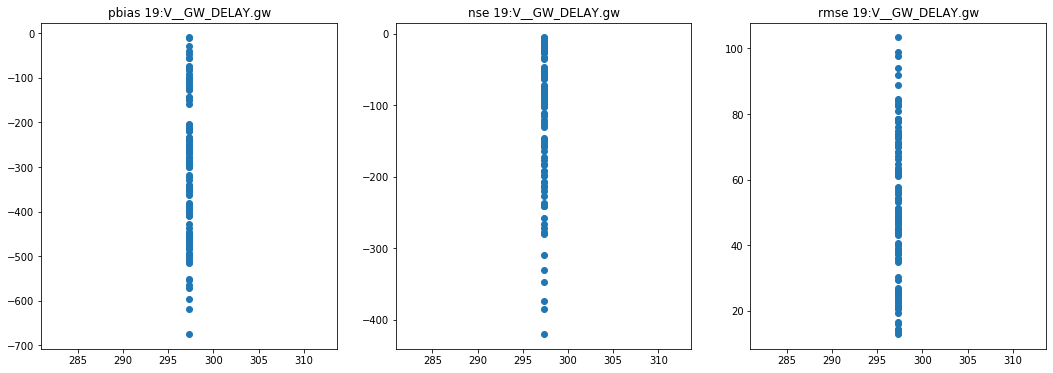

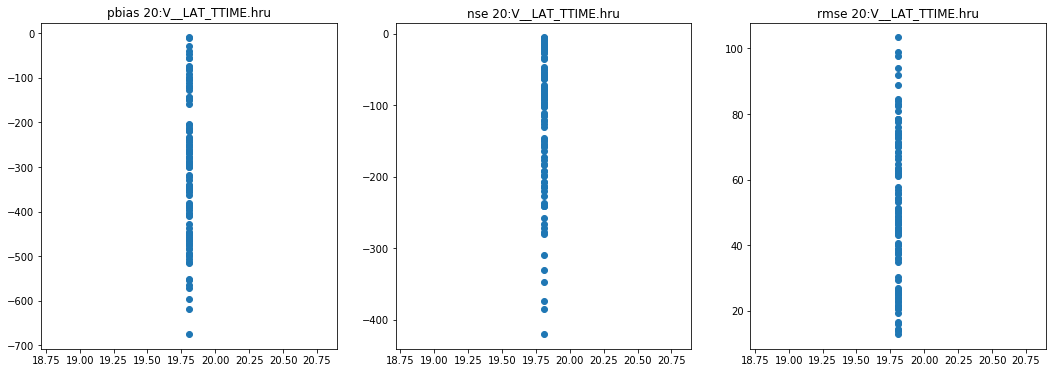

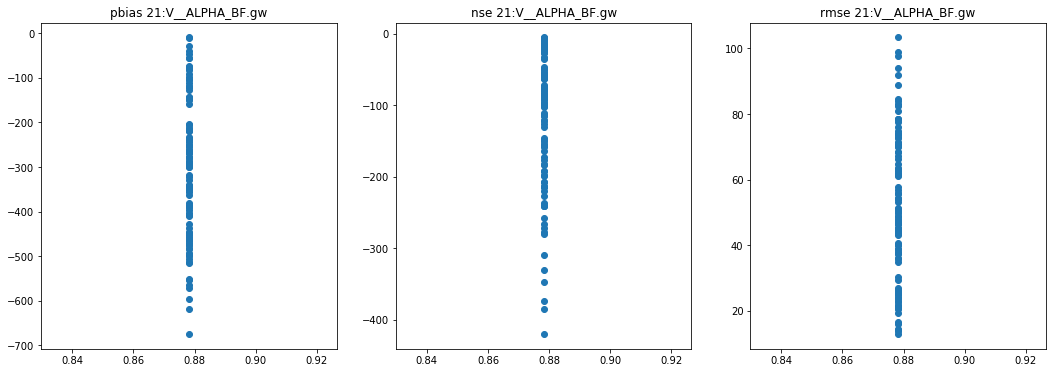

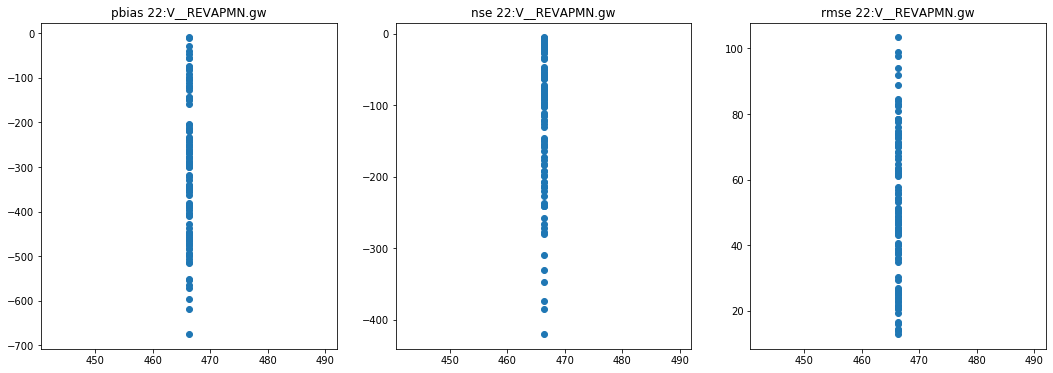

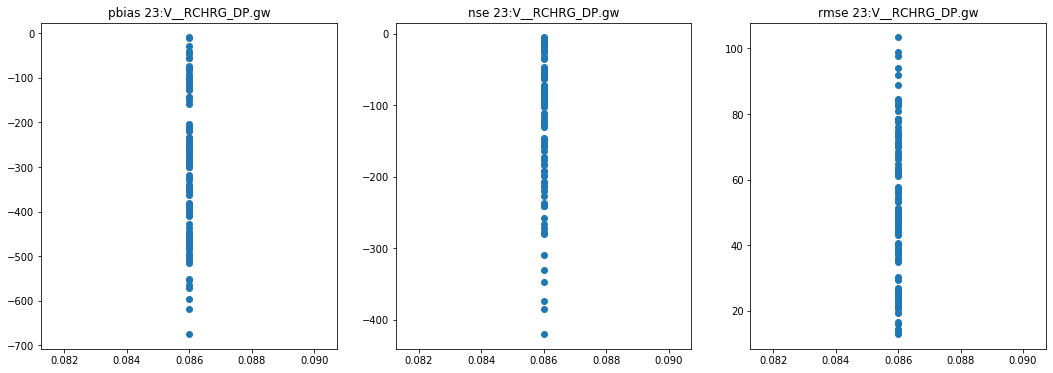

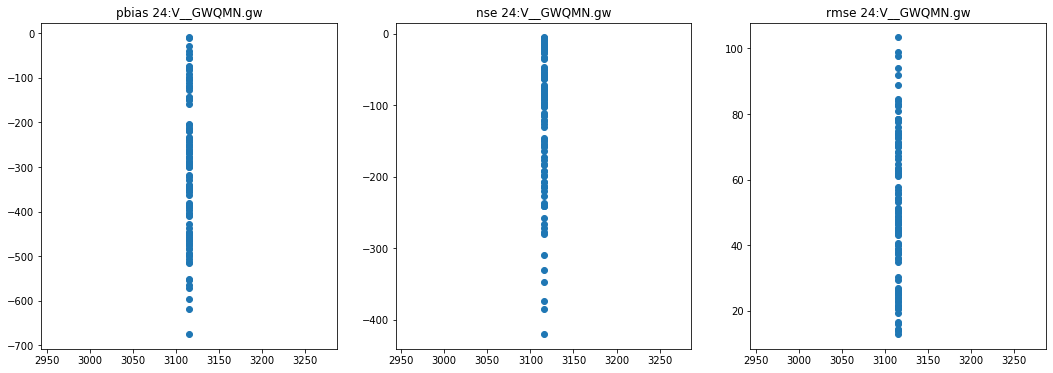

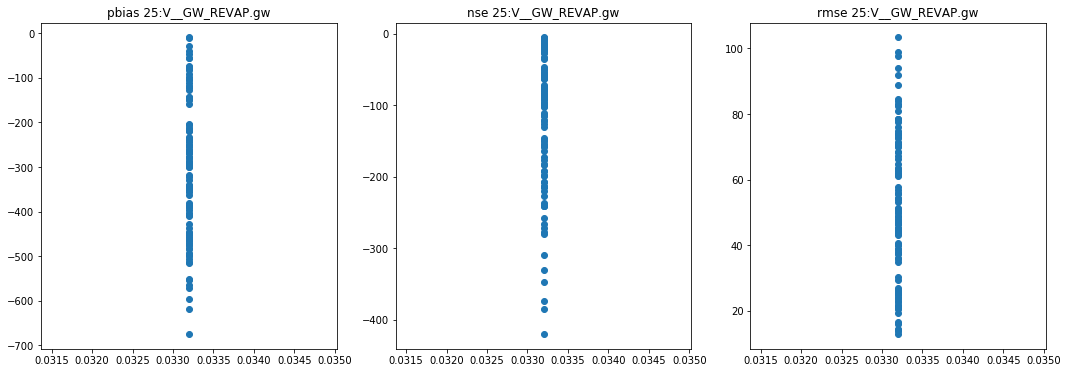

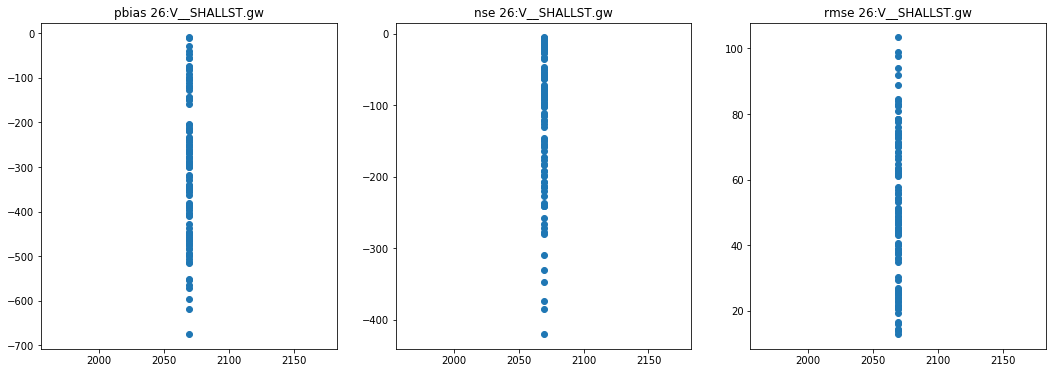

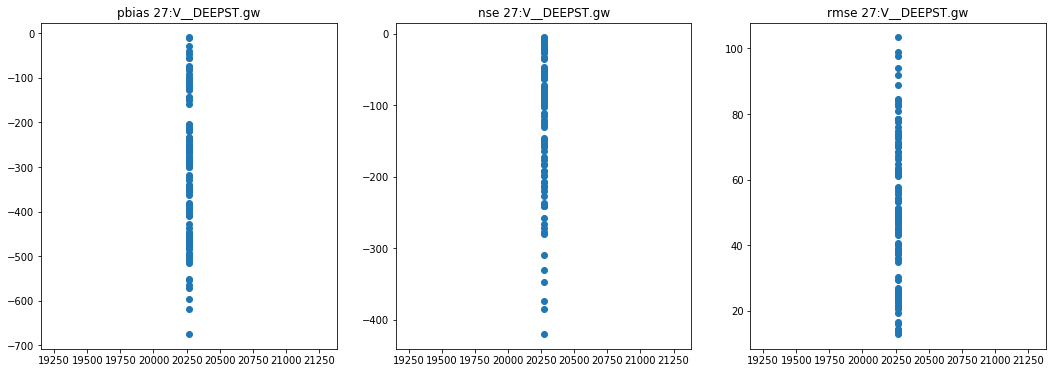

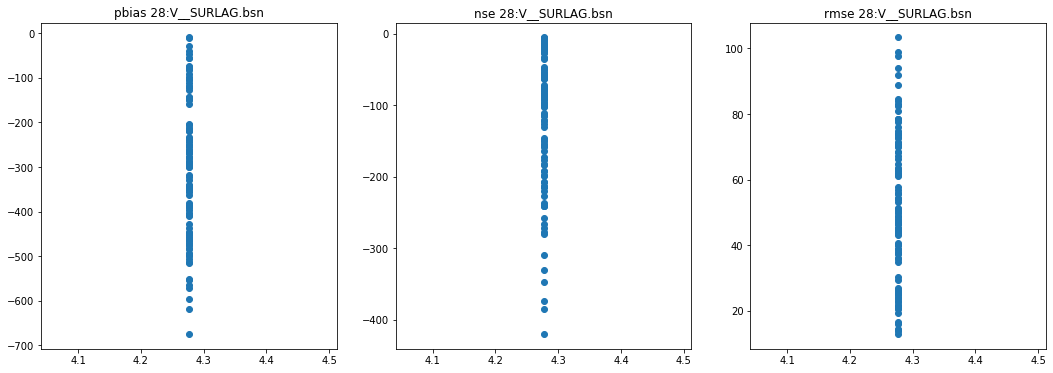

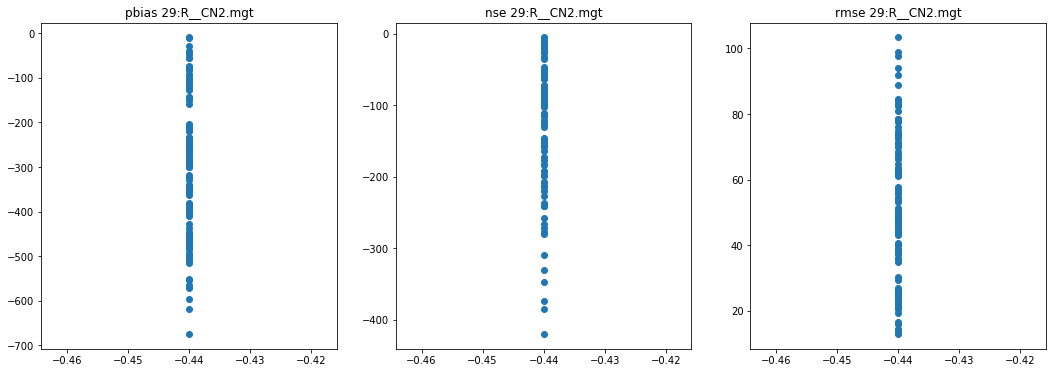

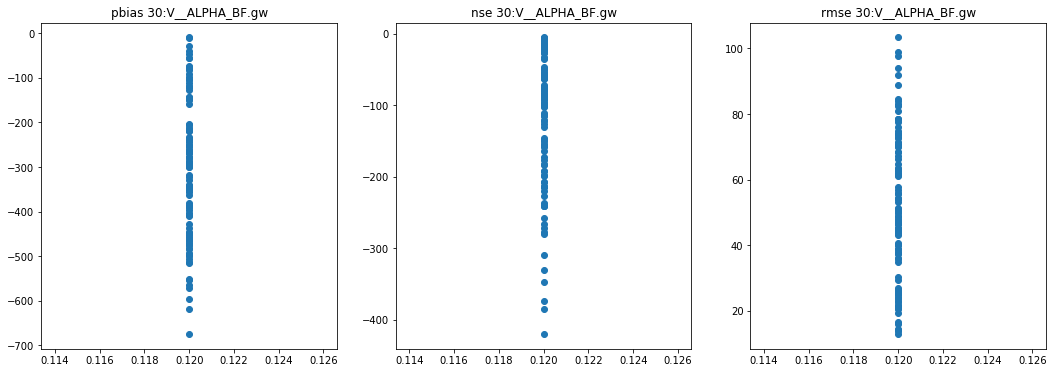

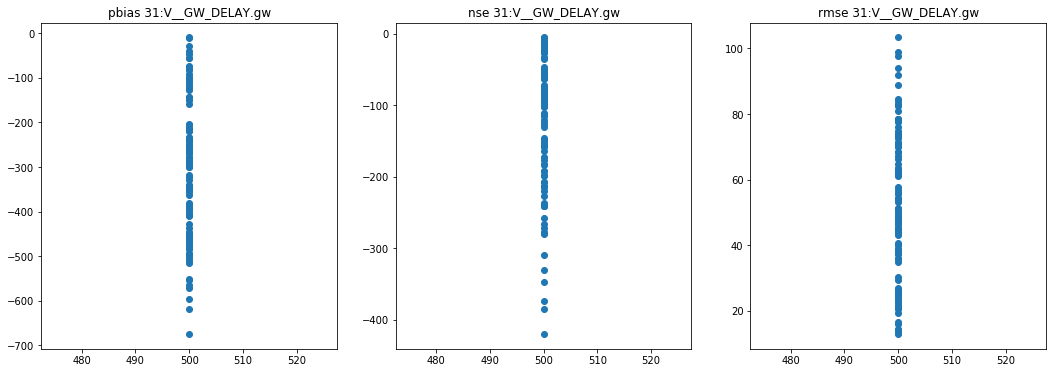

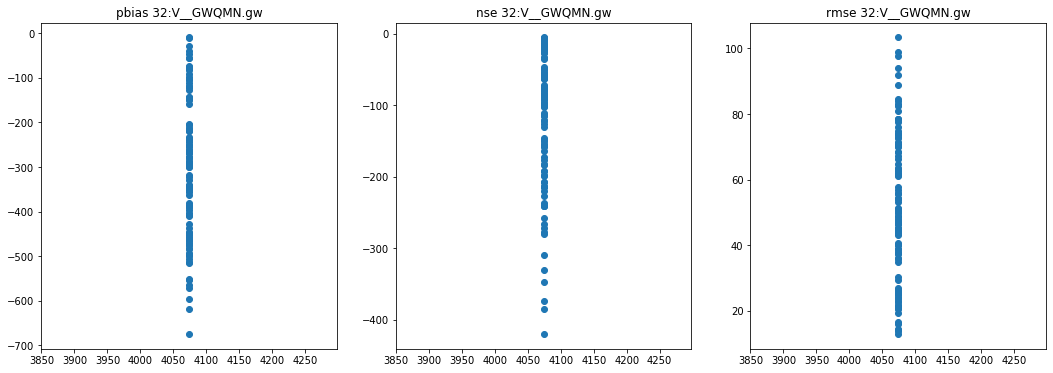

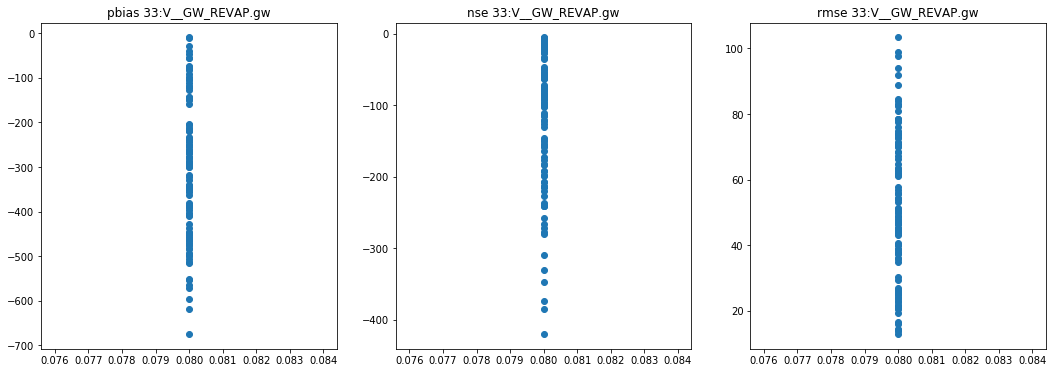

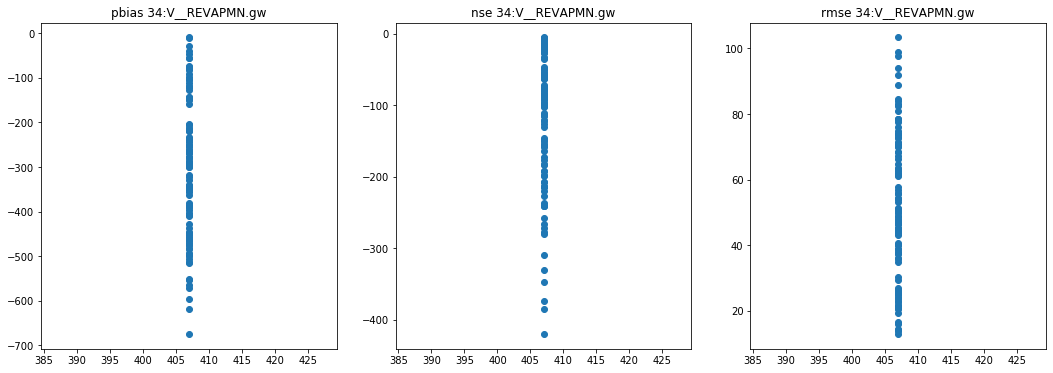

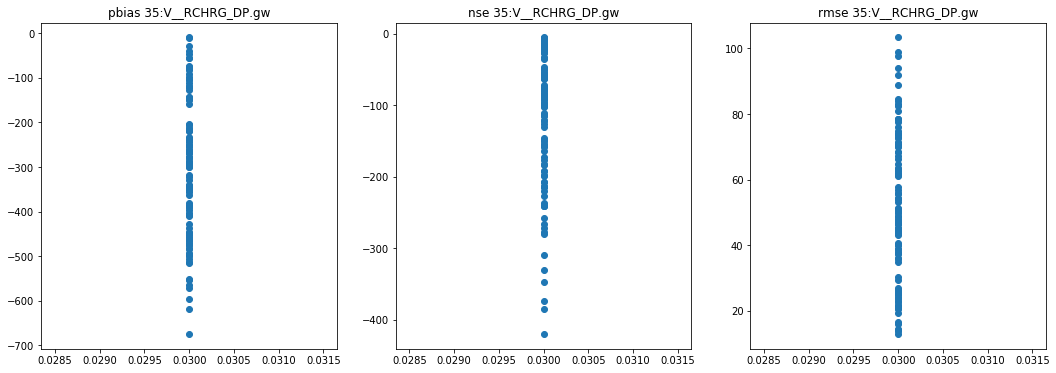

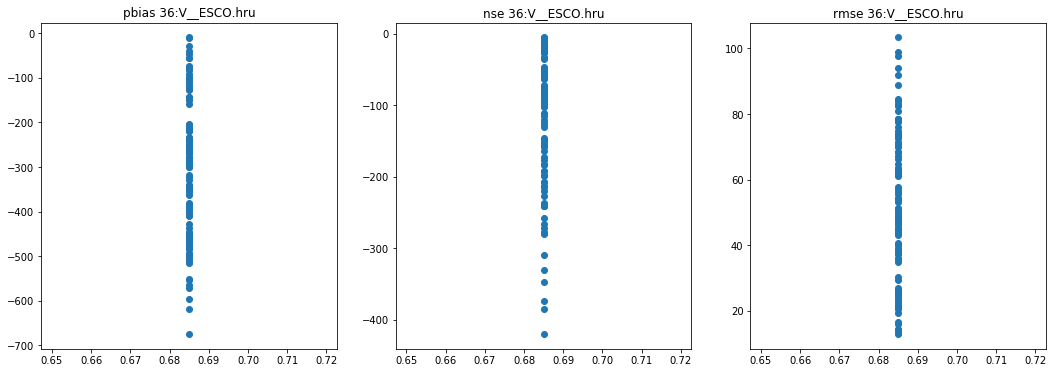

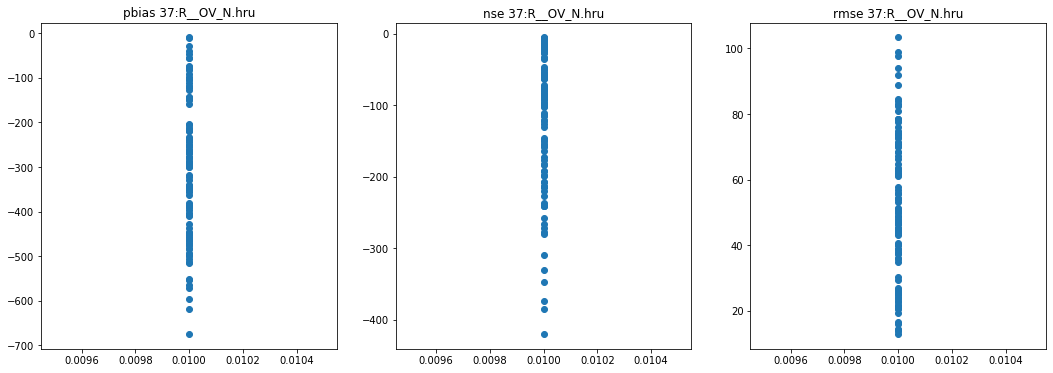

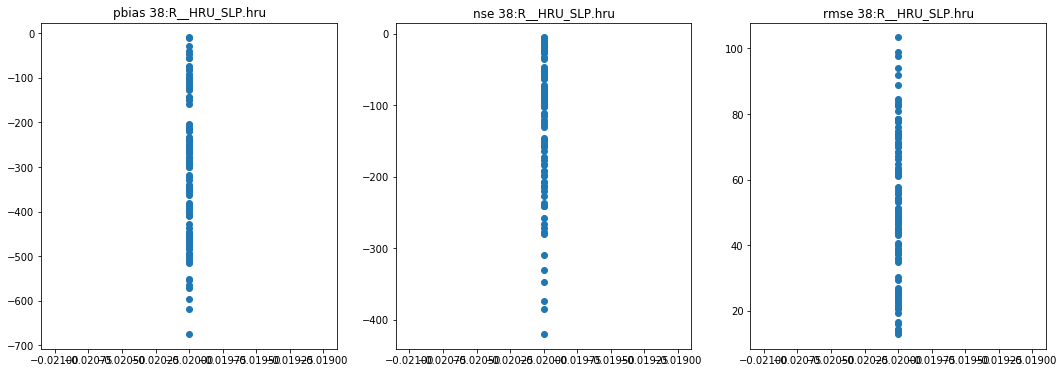

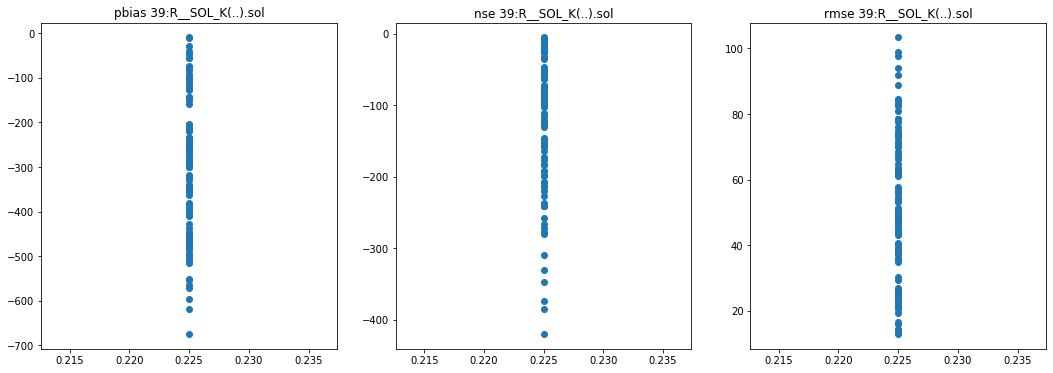

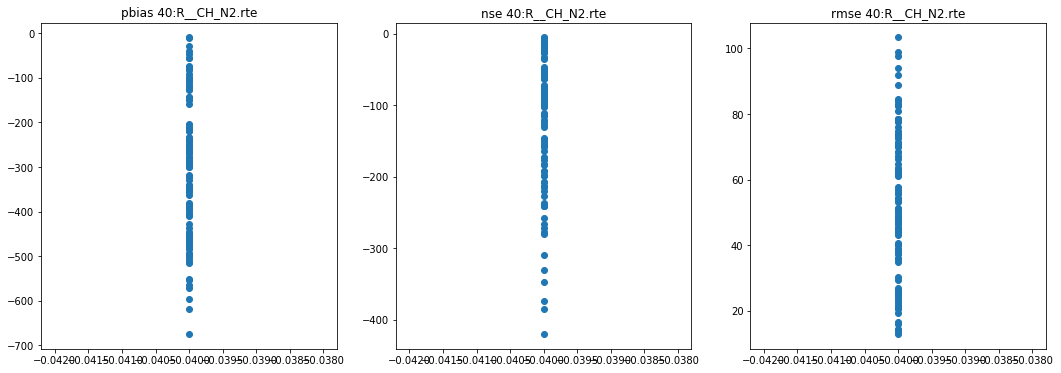

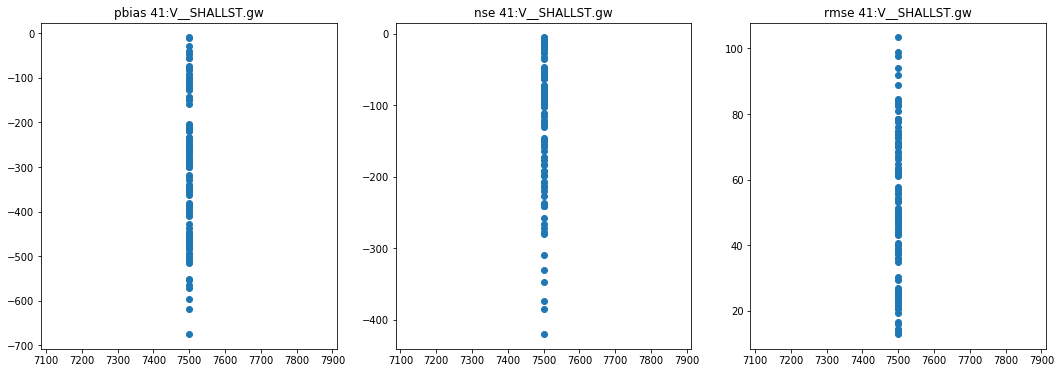

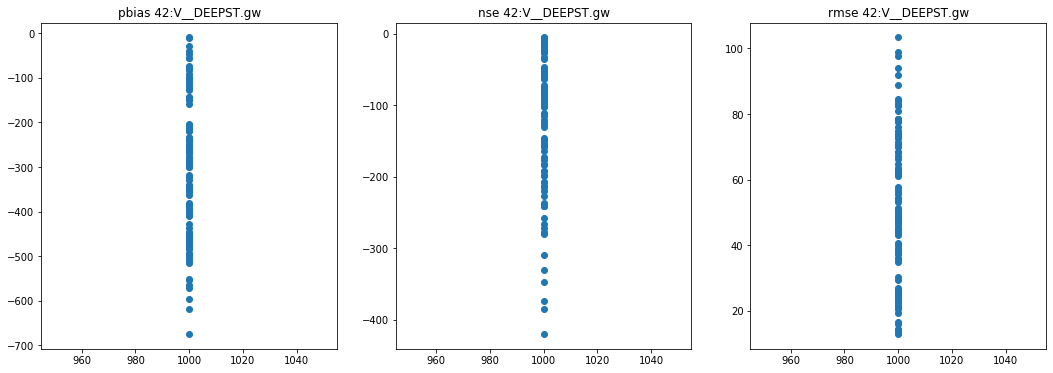

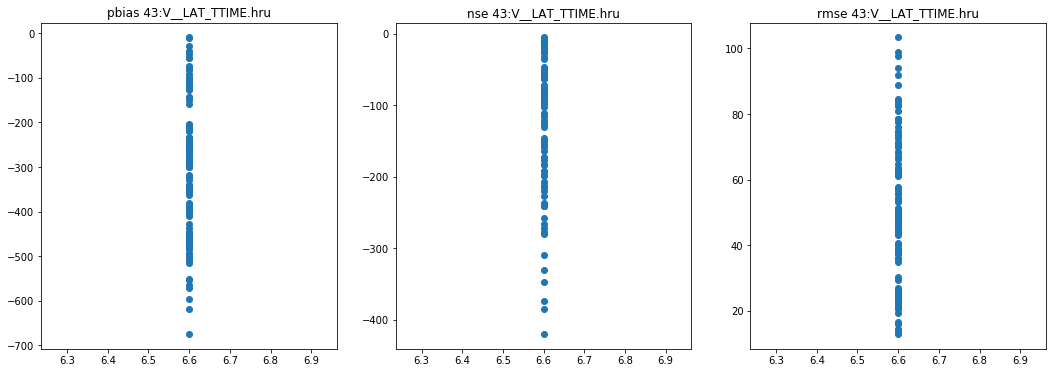

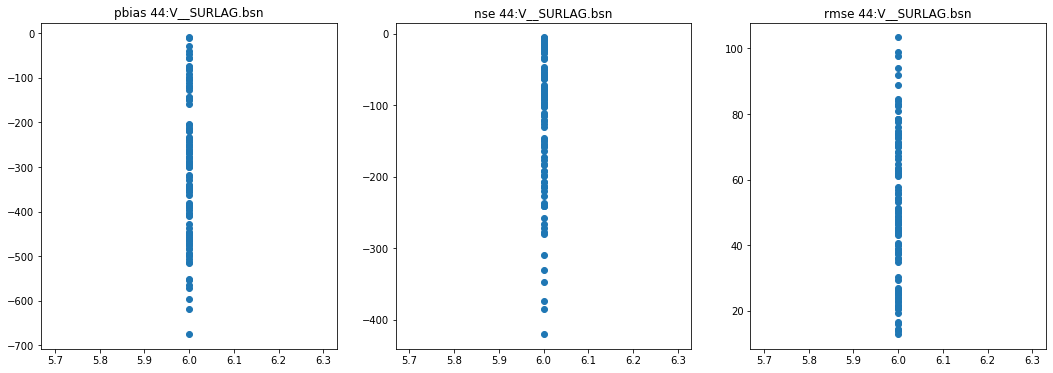

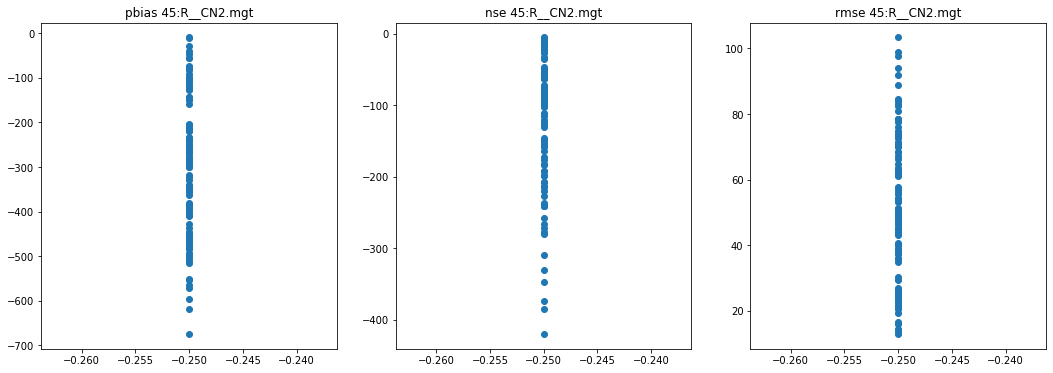

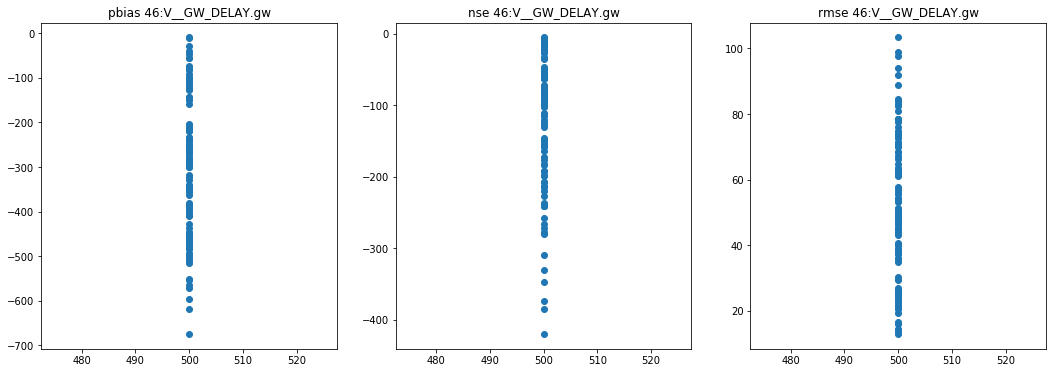

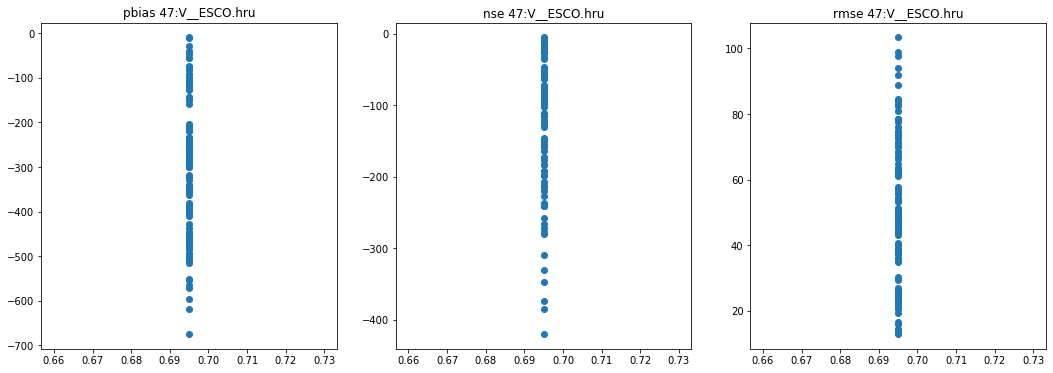

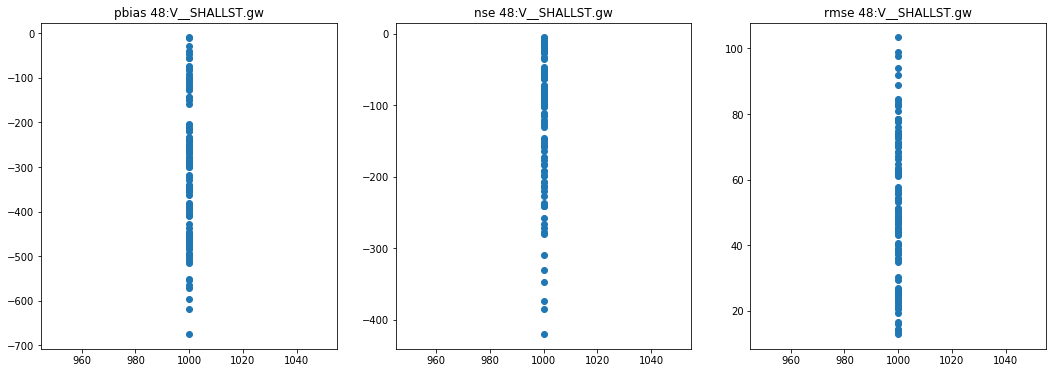

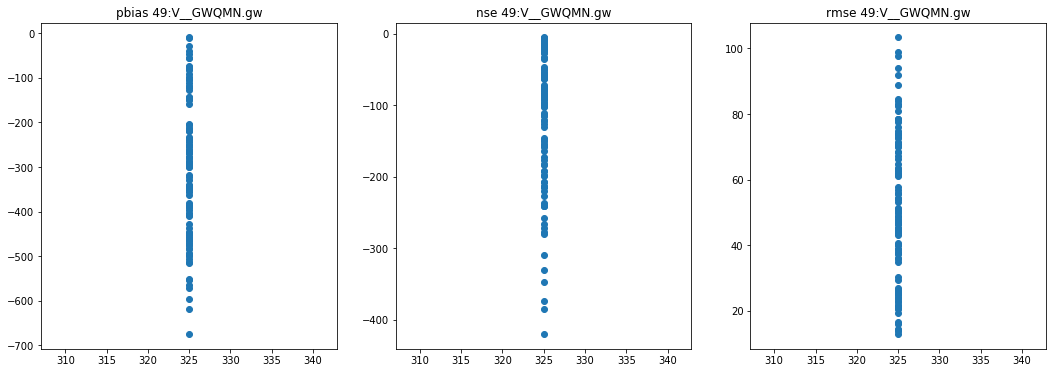

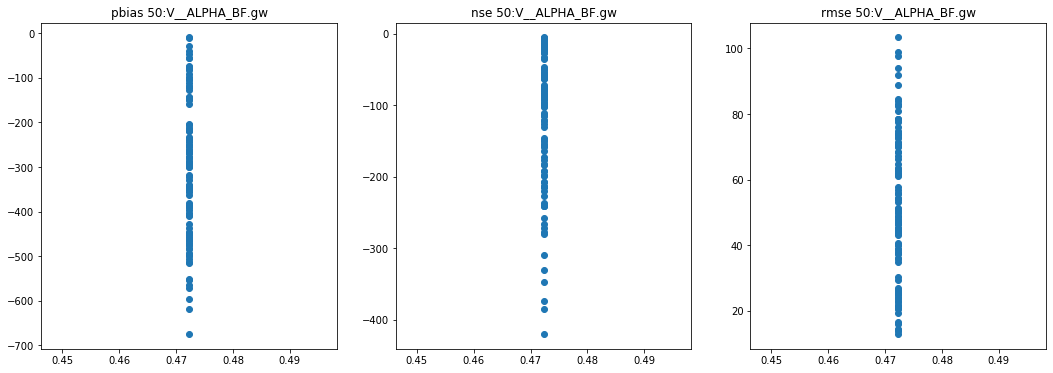

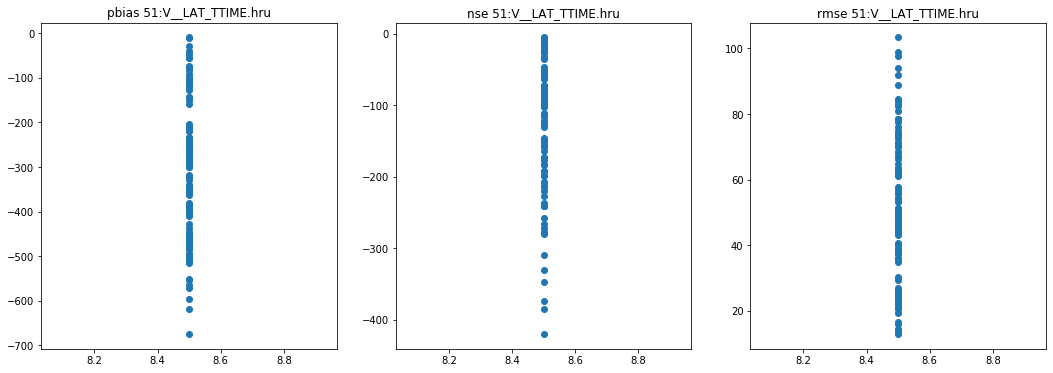

In [26]:
var_name = 'SED_OUT_14'
# periodo calib 4-12 23-108
# period valid 109 ate o final


# nse,kge, kgeprime, kgenp, rmse, mare, pbias
observed_data = observed[variable_id[var_name]]
simulated_data = extracted[variable_id[var_name]]


#periodo calibracao sem 2004
#observed_data = pd.concat([observed_data.loc[4:12], observed_data.loc[23:108]])
#simulated_data = pd.concat([simulated_data.loc[4:12], simulated_data.loc[23:108]])


# periodo de calibracao (2003 a 2011)
#observed_data = pd.concat([observed_data.loc[1:108]])
#simulated_data = pd.concat([simulated_data.loc[1:108]])

# periodo de validacao (2011 ate o final)
#observed_data = pd.concat([observed_data.loc[109:]])
#simulated_data = pd.concat([simulated_data.loc[109:]])


# Apresenta dados simulados
plt.figure(figsize=(18, 6))
l = plt.plot(simulated_data, color='red', label='_simulado')
#l=plt.legend()
#l.get_texts()[0].set_text('make it short')
plt.title(var_name)

# Apresenta dados simulados

plt.plot(observed_data, color='blue', label='observado')
plt.title(var_name)
plt.legend(loc="upper left")
plt.show()
#plt.legend(teste_data.columns)

pbias = evaluation_metric('pbias', simulated_data, observed_data)
nse = evaluation_metric('nse', simulated_data, observed_data)
rmse = evaluation_metric('rmse', simulated_data, observed_data)

best_pbias = sorted(enumerate(pbias,1), key=lambda pbias: abs(pbias[1]))
best_nse = sorted(enumerate(nse,1), key=lambda nse: abs(1 - nse[1]))
best_rmse = sorted(enumerate(rmse,1), key=lambda rmse: abs(rmse[1]))

iteration_number = best_pbias[0][0]
iteration_number = 64

# Apresenta dados simulados
plt.figure(figsize=(18, 6))
l = plt.plot(simulated_data[iteration_number].values, color='red', label='model ({})'.format(iteration_number) )
plt.title(var_name)

# Apresenta dados simulados

plt.plot(observed_data.values, color='blue', label='observed')
plt.title(var_name)
plt.legend(loc="upper left")
plt.show()
#plt.legend(teste_data.columns)

i_pbias = evaluation_metric('pbias', simulated_data[iteration_number], observed_data)
i_nse = evaluation_metric('nse', simulated_data[iteration_number], observed_data)
i_rmse = evaluation_metric('rmse', simulated_data[iteration_number], observed_data)
i_kge = evaluation_metric('kge', simulated_data[iteration_number], observed_data)
print('pbias: {}'.format(i_pbias))
print('nse: {}'.format(i_nse))
print('rmse: {}'.format(i_rmse))
print('kge: {}'.format(i_kge[0]))



for par in params.columns:
    plt.figure(figsize=(18, 6))
    plt.subplot(1,3,1)
    plt.plot(params[par], pbias, 'o')
    plt.title('pbias ' + par)
    plt.subplot(1,3,2)
    plt.plot(params[par], nse, 'o')
    plt.title('nse ' + par)
    plt.subplot(1,3,3)
    plt.plot(params[par], rmse, 'o')
    plt.title('rmse ' + par)
    
    plt.show()

## Prepara graficos e estatisticas para relatorio

In [151]:
def br2(obs, sim):
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs, sim)
    b = abs(slope)
    r = r_value
    if b <= 1:
        mbr2 = b * r**2
    else:
        mbr2 = r**2/b
    return mbr2

<Figure size 1296x432 with 0 Axes>

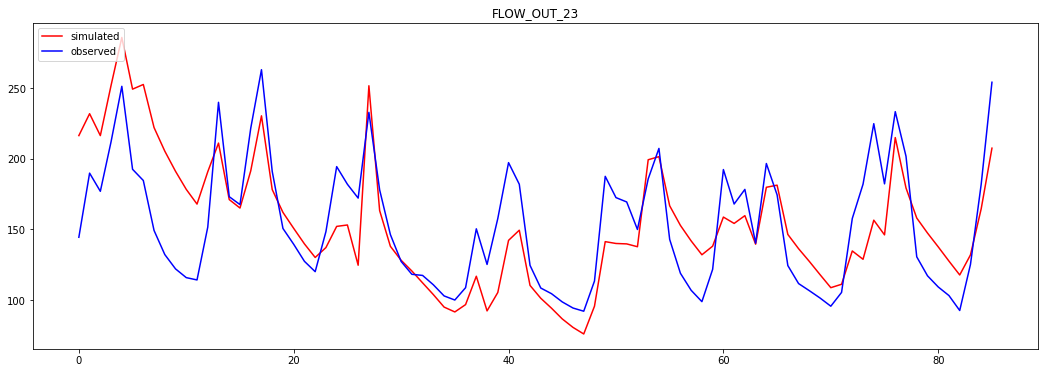

FLOW_OUT_23
pbias: [-0.77878088]
nse: [0.43102876]
rmse: [32.69114127]
kge: [0.72289432]
br2: 0.39199922501463325
Mean_sim(Mean_obs): 154.32697674418606(153.1343953488372)


In [200]:
var_name = 'FLOW_OUT_23'
# periodo calib 4-12 23-108
# period valid 109 ate o final


# nse,kge, kgeprime, kgenp, rmse, mare, pbias
observed_data = observed[variable_id[var_name]]
simulated_data = extracted[variable_id[var_name]]


#periodo calibracao sem 2004
#observed_data = pd.concat([observed_data.loc[4:12], observed_data.loc[23:108]])
#simulated_data = pd.concat([simulated_data.loc[4:12], simulated_data.loc[23:108]])
observed_data = pd.concat([observed_data.loc[23:108]])
simulated_data = pd.concat([simulated_data.loc[23:108]])


# periodo de calibracao (2003 a 2011)
#observed_data = pd.concat([observed_data.loc[1:108]])
#simulated_data = pd.concat([simulated_data.loc[1:108]])

# periodo de validacao (2011 ate o final)
#observed_data = pd.concat([observed_data.loc[109:]])
#simulated_data = pd.concat([simulated_data.loc[109:]])

# periodo de validacao cruzada (2005 ate o final) - sem os pico estranho em 2004
#observed_data = pd.concat([observed_data.loc[23:]])
#simulated_data = pd.concat([simulated_data.loc[23:]])


# Apresenta dados simulados
plt.figure(figsize=(18, 6))

pbias = evaluation_metric('pbias', simulated_data, observed_data)
nse = evaluation_metric('nse', simulated_data, observed_data)
rmse = evaluation_metric('rmse', simulated_data, observed_data)

best_pbias = sorted(enumerate(pbias,1), key=lambda pbias: abs(pbias[1]))
best_nse = sorted(enumerate(nse,1), key=lambda nse: abs(1 - nse[1]))
best_rmse = sorted(enumerate(rmse,1), key=lambda rmse: abs(rmse[1]))

iteration_number = best_nse[0][0]
# Apresenta dados simulados
plt.figure(figsize=(18, 6))
l = plt.plot(simulated_data[iteration_number].values, color='red', label='simulated'.format(iteration_number) )
plt.title(var_name)

# Apresenta dados simulados

plt.plot(observed_data.values, color='blue', label='observed')
plt.title(var_name)
plt.legend(loc="upper left")
plt.show()
#plt.legend(teste_data.columns)

i_pbias = evaluation_metric('pbias', simulated_data[iteration_number], observed_data)
i_nse = evaluation_metric('nse', simulated_data[iteration_number], observed_data)
i_rmse = evaluation_metric('rmse', simulated_data[iteration_number], observed_data)
i_kge = evaluation_metric('kge', simulated_data[iteration_number], observed_data)
mean_sim = simulated_data[iteration_number].mean()
mean_obs = observed_data.iloc[:, 0].mean()

print(var_name)
print('pbias: {}'.format(i_pbias))
print('nse: {}'.format(i_nse))
print('rmse: {}'.format(i_rmse))
print('kge: {}'.format(i_kge[0]))
print('br2: {}'.format(br2( observed_data.iloc[:,0], simulated_data[iteration_number])))
print('Mean_sim(Mean_obs): {}({})'.format(mean_sim,mean_obs))


In [ ]:
Variable           p-factor  r-factor  R2    NS     bR2      MSE       SSQR       PBIAS  KGE  RSR   MNS   VOL_FR  ---  Mean_sim(Mean_obs)   StdDev_sim(StdDev_obs)
FLOW_OUT_14        0.34      0.00      0.66  0.43   0.6420   2.9e+003  6.5e+002   -4.6  0.67  0.76  0.31  0.96          254.12(242.89)          89.73(71.09)
